# MCMC (Markov Chain Monte Carlo)

GPflow allows you to approximate the posterior over the latent functions of its models (and over the hyperparemeters after setting a prior for those) using Hamiltonian Monte Carlo (HMC)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import tensorflow as tf
import tensorflow_probability as tfp

import gpflow
from gpflow.ci_utils import ci_niter, is_continuous_integration
from multiclass_classification import plot_from_samples, colors

gpflow.config.set_default_float(np.float64)
gpflow.config.set_default_jitter(1e-4)
gpflow.config.set_default_summary_fmt("notebook")
# convert to float64 for tfp to play nicely with gpflow in 64
f64 = gpflow.utilities.to_default_float

tf.random.set_seed(123)


%matplotlib inline


In this notebook, we provide three examples
* [Example 1](#example_1): Sampling hyperparameters in Gaussian process regression
* [Example 2](#example_2): Sparse Variational MC applied to the multiclass classification problem
* [Example 3](#example_3): Full Bayesian inference for Gaussian process models

<a id='example_1'></a>
## Example 1: GP regression

We first consider the GP regression (with Gaussian noise) for which the marginal likelihood $p(\mathbf y\,|\,\theta)$ can be computed exactly.

The GPR model parameterized by $\theta = [\tau]$ is given by
$$ Y_i = f(X_i) + \varepsilon_i$$
where $f \sim \mathcal{GP}(\mu(.), k(., .))$, and $\varepsilon \sim \mathcal{N}(0, \tau^2 I)$.

See the [Basic (Gaussian likelihood) GP regression model](../basics/regression.ipynb) for more details on GPR and for a treatment of the direct likelihood maximization.



### Data for a one-dimensional regression problem

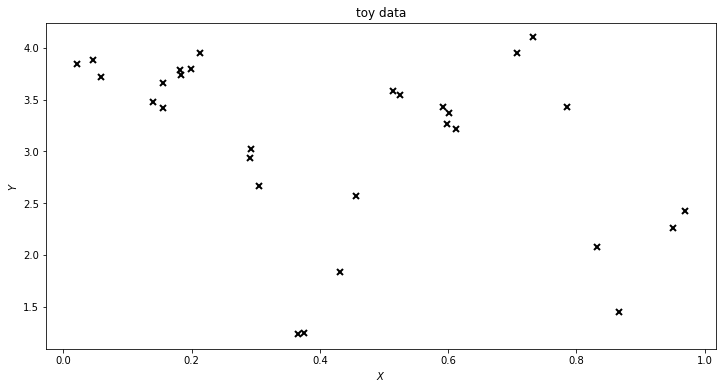

In [2]:
rng = np.random.RandomState(42)

N = 30
X = rng.rand(N,1)
Y = np.sin(12*X) + 0.66*np.cos(25*X) + rng.randn(N,1)*0.1 + 3
data = (X, Y)

plt.figure(figsize=(12,6))
plt.plot(X, Y, 'kx', mew=2)
plt.xlabel('$X$')
plt.ylabel('$Y$')
plt.title('toy data')
plt.show()

### MCMC for hyperparameters $\theta$

We now want to sample from the posterior over $\theta$: 
$$p(\theta|\mathbf{y}) \propto p(\mathbf{y}|\theta)p(\theta)$$

Firstly, we build the GPR model.

In [3]:
kernel = gpflow.kernels.Matern52(lengthscale=0.3)

meanf = gpflow.mean_functions.Linear(1.0, 0.0)
model = gpflow.models.GPR(data, kernel, meanf)
model.likelihood.variance.assign(0.01)

<tf.Variable 'UnreadVariable' shape=() dtype=float64, numpy=-4.600266525158267>

Secondly, we initialize the model to the maximum likelihood solution.

In [4]:
optimizer = gpflow.optimizers.Scipy()

@tf.function()
def objective():
    return - model.log_marginal_likelihood()
optimizer.minimize(objective, variables=model.trainable_variables)

print(f'log likelihood at optimum: {model.log_likelihood()}')

log likelihood at optimum: -2.437136697070862


Thirdly, we add priors to the hyperparameters.

In [5]:
# tfp.distributions dtype is inferred from parameters - so convert to 64-bit
model.kernel.lengthscale.prior = tfp.distributions.Gamma(f64(1.), f64(1.))
model.kernel.variance.prior = tfp.distributions.Gamma(f64(1.), f64(1.))
model.likelihood.variance.prior = tfp.distributions.Gamma(f64(1.), f64(1.))
model.mean_function.A.prior = tfp.distributions.Normal(f64(0.), f64(10.))
model.mean_function.b.prior = tfp.distributions.Normal(f64(0.), f64(10.))

gpflow.utilities.print_summary(model)

name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.A,Parameter,,Normal,True,"(1, 1)",float64,[[-1.06377032]]
GPR.mean_function.b,Parameter,,Normal,True,(),float64,3.5474603444013493
GPR.kernel.variance,Parameter,Softplus,Gamma,True,(),float64,0.9357531803025604
GPR.kernel.lengthscale,Parameter,Softplus,Gamma,True,(),float64,0.1039023714210777
GPR.likelihood.variance,Parameter,Softplus + Shift,Gamma,True,(),float64,0.0057567640543494175


We now sample from the posterior using HMC. 

In [6]:
hmc_helper = gpflow.optimizers.SamplingHelper(
    model.log_marginal_likelihood, model.trainable_parameters
)

hmc = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=hmc_helper.target_log_prob_fn, 
    num_leapfrog_steps=10, 
    step_size=0.01
)
adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
    hmc, 
    num_adaptation_steps=10, 
    target_accept_prob=f64(0.75),
    adaptation_rate=0.1
)

num_samples = 500

@tf.function
def run_chain_fn():
    return tfp.mcmc.sample_chain(
        num_results=num_samples, 
        num_burnin_steps=300,
        current_state=hmc_helper.current_state, 
        kernel=adaptive_hmc,
        trace_fn = lambda _, pkr: pkr.inner_results.is_accepted
    )

samples, traces = run_chain_fn()
parameter_samples = hmc_helper.convert_constrained_values(samples)

**NOTE:** All the Hamiltonian MCMC sampling takes place in an unconstrained space (where constrained parameters have been mapped via a bijector to an unconstrained space). This makes the optimization, as required in the gradient step, much easier.

However, we often wish to sample the constrained parameter values, not the unconstrained one. The `SamplingHelper` helps us convert our unconstrained values to constrained parameter ones. 


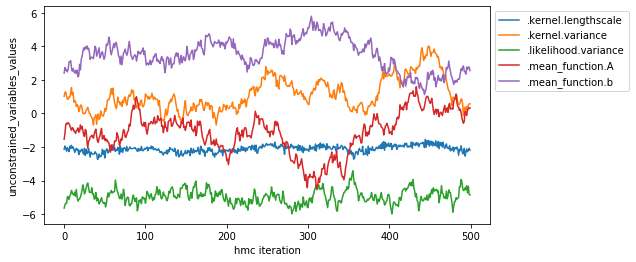

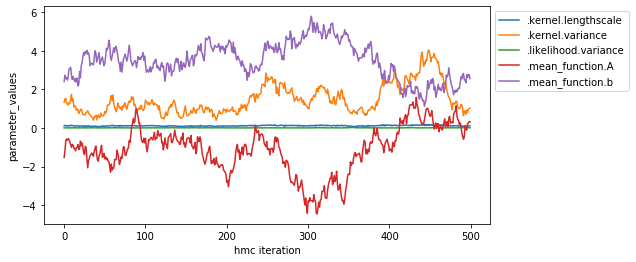

In [7]:
param_to_name = {param: name for name, param in 
                 gpflow.utilities.parameter_dict(model).items()}

def plot_samples(samples, y_axis_label):

    plt.figure(figsize=(8,4))
    for val, param in zip(samples, model.parameters):
        plt.plot(tf.squeeze(val), label=param_to_name[param])
    plt.legend(bbox_to_anchor=(1., 1.))
    plt.xlabel('hmc iteration')
    plt.ylabel(y_axis_label);


plot_samples(samples, 'unconstrained_variables_values')
plot_samples(parameter_samples, 'parameter_values')

You can also inspect the marginal distribution of samples.

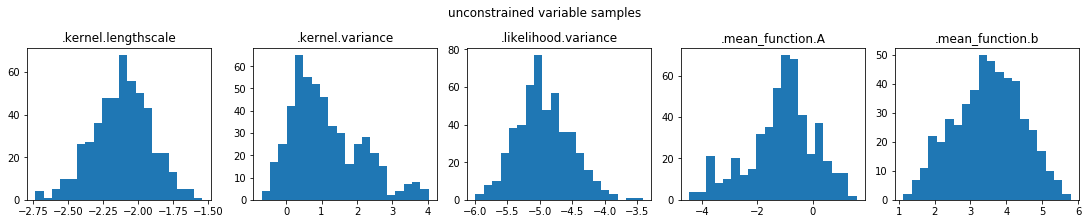

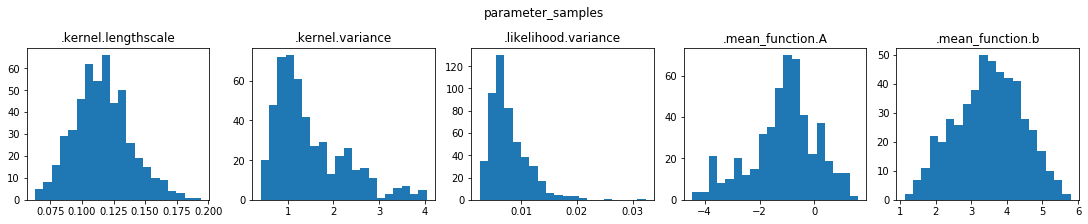

In [8]:
def marginal_samples(samples, y_axis_label):
    fig, axarr = plt.subplots(1, len(param_to_name), figsize=(15,3), constrained_layout=True)
    for i, param in enumerate(model.trainable_parameters):
        ax = axarr[i]
        ax.hist(np.stack(samples[i]).reshape(-1,1),bins=20)
        ax.set_title(param_to_name[param])
    fig.suptitle(y_axis_label);
    plt.show()
marginal_samples(samples, 'unconstrained variable samples')
marginal_samples(parameter_samples, 'parameter_samples')



**NOTE:** The sampler runs in unconstrained space (so that positive parameters remain positive, and parameters that are not trainable are ignored).

For serious analysis you most certainly want to run the sampler longer, with multiple chains and convergence checks. This will do for illustration though!


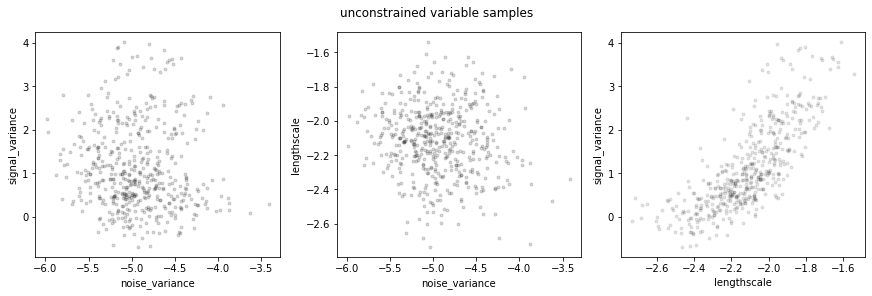

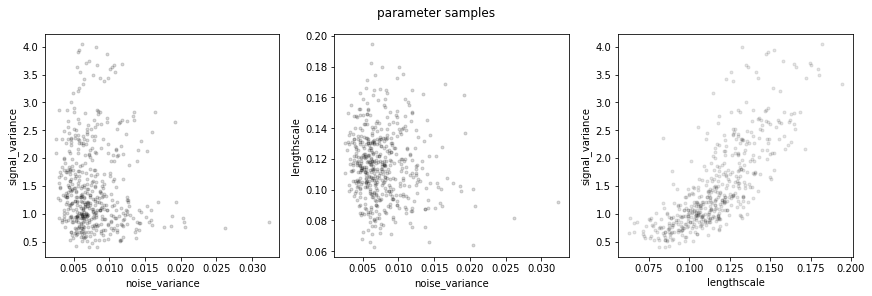

In [9]:
name_to_index = {param_to_name[param]: i for i, param in 
                 enumerate(model.trainable_parameters)}

def plot_joint_marginals(samples, y_axis_label):
    f, axs = plt.subplots(1,3, figsize=(12,4), constrained_layout=True)

    axs[0].plot(samples[name_to_index['.likelihood.variance']],
                samples[name_to_index['.kernel.variance']], 'k.', alpha = 0.15)
    axs[0].set_xlabel('noise_variance')
    axs[0].set_ylabel('signal_variance')

    axs[1].plot(samples[name_to_index['.likelihood.variance']],
                samples[name_to_index['.kernel.lengthscale']], 'k.', alpha = 0.15)
    axs[1].set_xlabel('noise_variance')
    axs[1].set_ylabel('lengthscale')

    axs[2].plot(samples[name_to_index['.kernel.lengthscale']],
                samples[name_to_index['.kernel.variance']], 'k.', alpha = 0.1)
    axs[2].set_xlabel('lengthscale')
    axs[2].set_ylabel('signal_variance')
    f.suptitle(y_axis_label);
    plt.show()

plot_joint_marginals(samples, 'unconstrained variable samples')
plot_joint_marginals(parameter_samples, 'parameter samples')

To plot the posterior of predictions, we'll iterate through the samples and set the model state with each sample. Then, for that state (set of hyperparameters) we'll draw some samples from the prediction function.

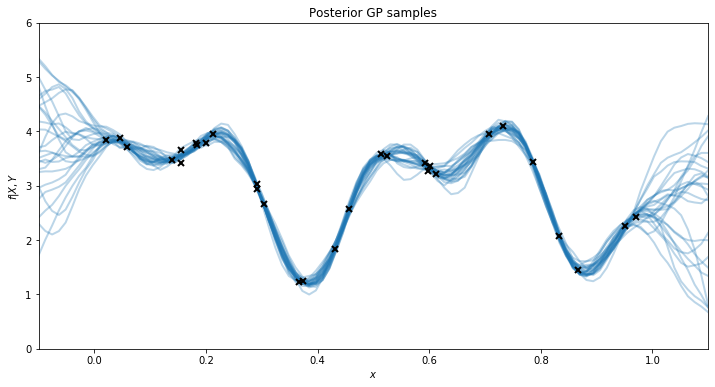

In [10]:
#plot the function posterior
xx = np.linspace(-0.1, 1.1, 100)[:,None]
plt.figure(figsize=(12, 6))

for i in range(0, num_samples, 20):
    for var, var_samples in zip(hmc_helper.current_state, samples):
        var.assign(var_samples[i])
    f = model.predict_f_samples(xx, 1)
    plt.plot(xx, f[0,:,:], 'C0', lw=2, alpha=0.3)

plt.plot(X, Y, 'kx', mew=2)
_ = plt.xlim(xx.min(), xx.max())
_ = plt.ylim(0, 6)
plt.xlabel('$x$')
plt.ylabel('$f|X,Y$')
plt.title('Posterior GP samples')

plt.show()

<a id='example_2'></a>
## Example 2: Sparse MC for multiclass classification

We now consider the multiclass classification problem (see the [Multiclass classification](../advanced/multiclass_classification.ipynb) notebook). Here the marginal likelihood is not available in closed form. Instead we use a sparse variational approximation where we approximate the posterior for each GP as $q(f_c) \propto p(f_c|\mathbf{u}_c)q(\mathbf{u}_c)$

In the standard Sparse Variational GP (SVGP) formulation, $q(\mathbf{u_c})$ is parameterized as a multivariate Gaussian.

An alternative is to directly sample from the optimal $q(\mathbf{u}_c)$; this is what Sparse Variational GP using MCMC (SGPMC) does. 

We first build a multiclass classification dataset.

In [11]:
# Generate data by sampling from RBF Kernel, and classifying with the argmax
C, N = 3, 100
X = rng.rand(N, 1)
kernel = gpflow.kernels.RBF(lengthscale=0.1)
K = kernel.K(X) + np.eye(N) * 1e-6

f = rng.multivariate_normal(mean=np.zeros(N), cov=K, size=(C)).T
Y = np.argmax(f, 1).reshape(-1,).astype(int)
# One-hot encoding
Y_hot = np.zeros((N, C), dtype=bool)
Y_hot[np.arange(N), Y] = 1

data = (X,Y)

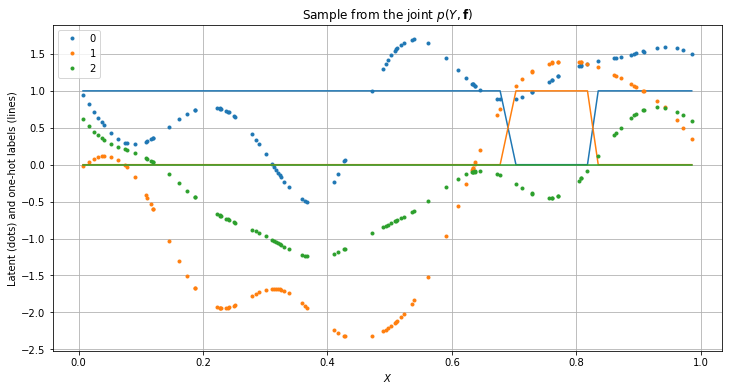

In [12]:
plt.figure(figsize=(12, 6))
order = np.argsort(X.reshape(-1,))

for c in range(C):  
    plt.plot(X[order], f[order, c], '.', color=colors[c], label=str(c))
    plt.plot(X[order], Y_hot[order, c], '-', color=colors[c])

plt.legend()
plt.xlabel('$X$')
plt.ylabel('Latent (dots) and one-hot labels (lines)')
plt.title('Sample from the joint $p(Y, \mathbf{f})$')
plt.grid()
plt.show()

We then build the SGPMC model.

In [13]:
kernel = gpflow.kernels.Matern32(lengthscale=0.1) + gpflow.kernels.White(variance=0.01)

model = gpflow.models.SGPMC(data, 
                 kernel=kernel,
                 likelihood=gpflow.likelihoods.MultiClass(3),
                 inducing_variable=X[::5].copy(), num_latent=3)
model.kernel.kernels[0].variance.prior = tfp.distributions.Gamma(f64(1.), f64(1.))
model.kernel.kernels[0].lengthscale.prior = tfp.distributions.Gamma(f64(2.), f64(2.))
model.kernel.kernels[1].variance.trainable = False

gpflow.utilities.print_summary(model)

name,class,transform,prior,trainable,shape,dtype,value
SGPMC.kernel.kernels[0].variance,Parameter,Softplus,Gamma,True,(),float64,1.0
SGPMC.kernel.kernels[0].lengthscale,Parameter,Softplus,Gamma,True,(),float64,0.10000000000000007
SGPMC.kernel.kernels[1].variance,Parameter,Softplus,,False,(),float64,0.009999999999999893
SGPMC.likelihood.invlink.epsilon,Parameter,Sigmoid,Beta,False,(),float64,0.0010000000000000005
SGPMC.inducing_variable.Z,Parameter,,,True,"(20, 1)",float64,[[0.77127035...
SGPMC.V,Parameter,,Normal,True,"(20, 3)",float64,"[[0., 0., 0...."


The chain of samples for $\mathbf{u}_c, \theta$ is initialized at the value maximizing  $p(Y|\mathbf{u}_c, \theta)$.

In [14]:
optimizer = gpflow.optimizers.Scipy()


@tf.function()
def objective():
    return - model.log_marginal_likelihood()


optimizer.minimize(objective, variables=model.trainable_variables, options={'maxiter':20})
print(f'log likelihood at optimum: {model.log_likelihood()}')

Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().


log likelihood at optimum: -8.162230760113518


Sampling starts with a 'burn in' period.

In [15]:
burn = ci_niter(100)
thin = ci_niter(10)

In [16]:
num_samples = 500

hmc_helper =  gpflow.optimizers.SamplingHelper(
    model.log_marginal_likelihood, model.trainable_parameters
)

hmc = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=hmc_helper.target_log_prob_fn, 
    num_leapfrog_steps=10, 
    step_size=0.01
)

adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
    hmc, 
    num_adaptation_steps=10, 
    target_accept_prob=f64(.75),
    adaptation_rate=0.1
)

@tf.function
def run_chain_fn():
    return tfp.mcmc.sample_chain(
        num_results=num_samples, 
        num_burnin_steps=100,
        current_state=hmc_helper.current_state, 
        kernel=adaptive_hmc,
        trace_fn = lambda _, pkr: pkr.inner_results.is_accepted
    )

samples, _ = run_chain_fn()

Statistics of the posterior samples can now be reported.

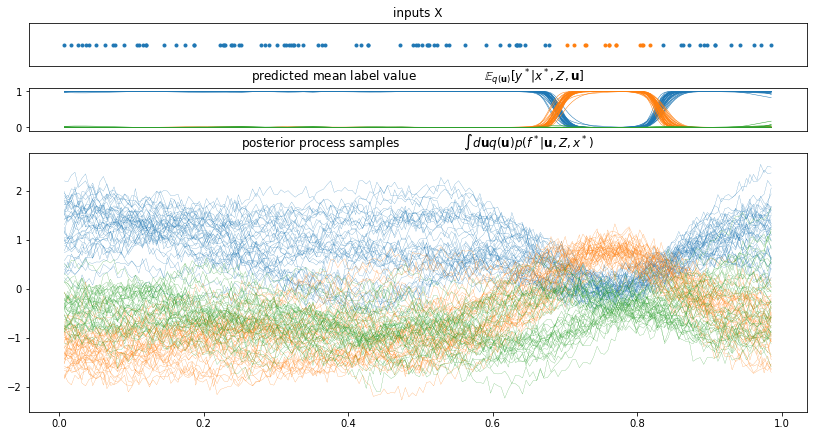

In [17]:
plot_from_samples(model, X, Y, samples, burn, thin)

You can also display the sequence of sampled hyperparameters.

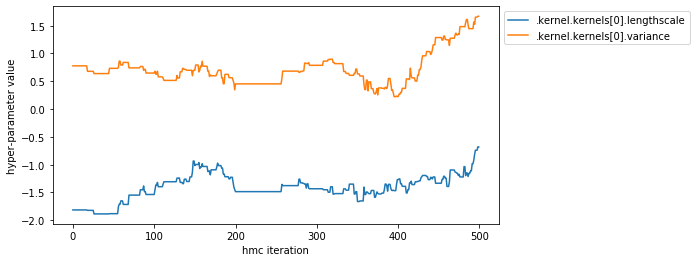

In [18]:
param_to_name = {param: name for name, param in 
                 gpflow.utilities.parameter_dict(model).items()}
name_to_index = {param_to_name[param]: i for i, param in 
                 enumerate(model.trainable_parameters)}
hyperparameters = ['.kernel.kernels[0].lengthscale',
                   '.kernel.kernels[0].variance']

plt.figure(figsize=(8,4))
for hp in hyperparameters:
    plt.plot(samples[name_to_index[hp]], label=hp)
plt.legend(bbox_to_anchor=(1., 1.))
plt.xlabel('hmc iteration')
plt.ylabel('hyper-parameter value');

<a id='example_3'></a>
## Example 3: Fully Bayesian inference for generalized GP models with HMC

You can construct very flexible models with Gaussian processes by combining them with different likelihoods (sometimes called 'families' in the GLM literature). This makes inference of the GP intractable because the likelihoods are not generally conjugate to the Gaussian process. The general form of the model is 
$$\theta \sim p(\theta)\\f \sim \mathcal {GP}(m(x; \theta),\, k(x, x'; \theta))\\y_i \sim p(y | g(f(x_i))\,.$$


To perform inference in this model, we'll run MCMC using Hamiltonian Monte Carlo (HMC) over the function values and the parameters $\theta$ jointly. The key to an effective scheme is rotation of the field using the Cholesky decomposition. We write:

$$\theta \sim p(\theta)\\v \sim \mathcal {N}(0,\, I)\\LL^\top = K\\f = m + Lv\\y_i \sim p(y | g(f(x_i))\,.$$

Joint HMC over $v$ and the function values is not widely adopted in the literature because of the difficulty in differentiating $LL^\top=K$. We've made this derivative available in TensorFlow, and so application of HMC is relatively straightforward. 

### Exponential Regression
We consider an exponential regression model: 
$$\theta \sim p(\theta)\\f \sim \mathcal {GP}(0, k(x, x'; \theta))\\f_i = f(x_i)\\y_i \sim \mathcal {Exp} (e^{f_i})$$

We'll use MCMC to deal with both the kernel parameters $\theta$ and the latent function values $f$. Firstly, generate a data set.

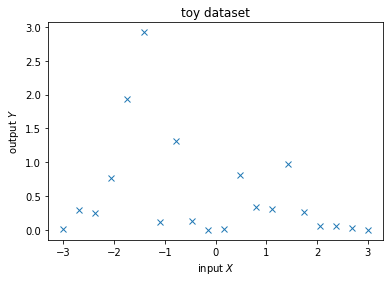

In [19]:
X = np.linspace(-3,3,20)
Y = rng.exponential(np.sin(X)**2)

plt.figure()
plt.plot(X,Y,'x')
plt.xlabel('input $X$')
plt.ylabel('output $Y$')
plt.title('toy dataset')
plt.show()

data = (X[:,None], Y[:,None])

GPflow's model for fully-Bayesian MCMC is called GPMC. It's constructed like any other model, but contains a parameter `V` which represents the centered values of the function. 

In [20]:
kernel = gpflow.kernels.Matern32() + gpflow.kernels.Bias()
likelihood = gpflow.likelihoods.Exponential()
model = gpflow.models.GPMC(data, kernel, likelihood)

The `V` parameter already has a prior applied. We'll add priors to the parameters also (these are rather arbitrary, for illustration). 

In [21]:
model.kernel.kernels[0].lengthscale.prior = tfp.distributions.Gamma(f64(1.), f64(1.))
model.kernel.kernels[0].variance.prior =  tfp.distributions.Gamma(f64(1.), f64(1.))
model.kernel.kernels[1].variance.prior = tfp.distributions.Gamma(f64(1.), f64(1.))

gpflow.utilities.print_summary(model)

name,class,transform,prior,trainable,shape,dtype,value
GPMC.kernel.kernels[0].variance,Parameter,Softplus,Gamma,True,(),float64,1.0
GPMC.kernel.kernels[0].lengthscale,Parameter,Softplus,Gamma,True,(),float64,1.0
GPMC.kernel.kernels[1].variance,Parameter,Softplus,Gamma,True,(),float64,1.0
GPMC.V,Parameter,,Normal,True,"(20, 1)",float64,[[0....


Running HMC is pretty similar to optimizing a model. GPflow has only HMC sampling for the moment, and it's a relatively vanilla implementation (no NUTS, for example). There are two things to tune, the step size (epsilon) and the number of steps $[L_{min}, L_{max}]$. Each proposal takes a random number of steps between $L_{min}$ and $L_{max}$, each of length $\epsilon$. 

We initialize HMC at the maximum a posteriori parameter value.

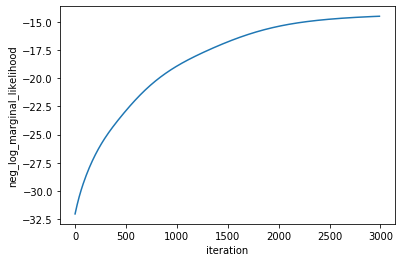

In [22]:
@tf.function()
def optimization_step(optimizer, model):
    with tf.GradientTape(watch_accessed_variables=False) as tape:
        tape.watch(model.trainable_variables)
        objective = - model.log_marginal_likelihood()
        grads = tape.gradient(objective, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return - objective

def run_adam(model, iterations):
    logf = []
    adam = tf.optimizers.Adam()
    for step in range(iterations):
        elbo = optimization_step(adam, model)
        if step % 10 == 0:
            logf.append(elbo.numpy())
    return logf

maxiter = ci_niter(3000)
logf = run_adam(model, maxiter) # start near Maximum a posteriori (MAP)

plt.plot(np.arange(maxiter)[::10], logf)
plt.xlabel('iteration')
plt.ylabel('neg_log_marginal_likelihood');



We then run the sampler,

In [23]:
num_samples = 500

hmc_helper =  gpflow.optimizers.SamplingHelper(
    model.log_marginal_likelihood, model.trainable_parameters
)

hmc = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=hmc_helper.target_log_prob_fn, 
    num_leapfrog_steps=10, 
    step_size=0.01
)

adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
    hmc, 
    num_adaptation_steps=10, 
    target_accept_prob=f64(.75),
    adaptation_rate=0.1
)

@tf.function
def run_chain_fn():
    return tfp.mcmc.sample_chain(
        num_results=num_samples, 
        num_burnin_steps=300,
        current_state=hmc_helper.current_state, 
        kernel=adaptive_hmc,
        trace_fn = lambda _, pkr: pkr.inner_results.is_accepted
    )

samples, _ = run_chain_fn()

And compute the posterior prediction on a grid for plotting purposes.

In [24]:
xtest = np.linspace(-4,4,100)[:,None]
f_samples = []

for i in range(num_samples):
    for var, var_samples in zip(hmc_helper.current_state, samples):
        var.assign(var_samples[i])
    f = model.predict_f_samples(xtest, 5)
    f_samples.append(f)
f_samples = np.vstack(f_samples)

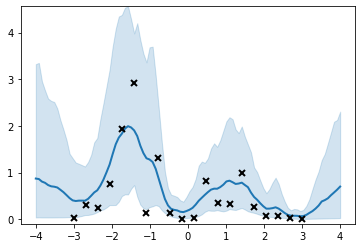

In [25]:
rate_samples = np.exp(f_samples[:, :, 0])

line, = plt.plot(xtest, np.mean(rate_samples, 0), lw=2)
plt.fill_between(xtest[:,0],
                 np.percentile(rate_samples, 5, axis=0),
                 np.percentile(rate_samples, 95, axis=0),
                 color=line.get_color(), alpha = 0.2)

plt.plot(X, Y, 'kx', mew=2)
plt.ylim(-0.1, np.max(np.percentile(rate_samples, 95, axis=0)));

You can also display the sequence of sampled hyperparameters.

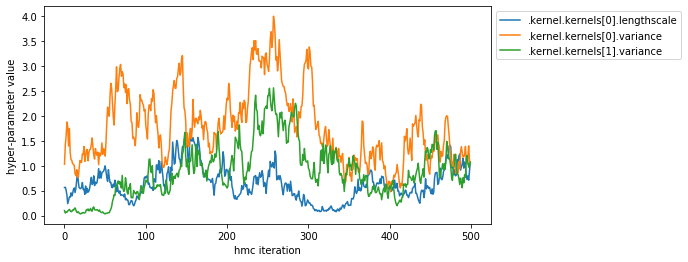

In [26]:
parameter_samples = hmc_helper.convert_constrained_values(samples)
param_to_name = {param: name for name, param in 
                 gpflow.utilities.parameter_dict(model).items()}
name_to_index = {param_to_name[param]: i for i, param in 
                 enumerate(model.trainable_parameters)}
hyperparameters = ['.kernel.kernels[0].lengthscale',
                   '.kernel.kernels[0].variance',
                   '.kernel.kernels[1].variance']


plt.figure(figsize=(8,4))
for hp in hyperparameters:
    plt.plot(parameter_samples[name_to_index[hp]], label=hp)
plt.legend(bbox_to_anchor=(1., 1.))
plt.xlabel('hmc iteration')
plt.ylabel('hyper-parameter value');

You can also inspect the marginal of the posterior samples.

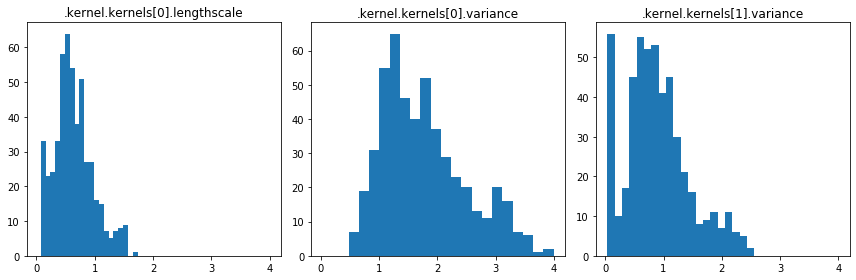

In [27]:
fig, axarr = plt.subplots(1, len(hyperparameters), sharex=True, figsize=(12,4))
for i, hyp in enumerate(hyperparameters):
    ax = axarr[i]
    ax.hist(parameter_samples[name_to_index[hyp]],bins=20)
    ax.set_title(hyp);
plt.tight_layout()